Team Members - section 003
- Yutian Wang(#85994168): Yutian contributed to data cleaning, formatting/standardization, visualization, time-series analysis using linear regression, and k-fold cross-validation.
- Ronin Cunningham(#43949676): Ronin contributed to implementing the PyTorch neural network to further analyze the weather and corn prices.
- Prayus Shrestha(#55823454): Prayus contributed to gathering the data through scraping and various APIs.
- Ebin Tomy(#44912301): Ebin contributed by writing the formal analysis and explaining each step.

# Weather Impacts on US Corn Prices

TO-DO: opening paragraph.  This study focuses on the relationship between weather and corn prices in US...

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from rnn_model import RNNModel
from sklearn.metrics import mean_absolute_error, mean_squared_error
from gru_model import GRUModel
# import shap

%matplotlib inline

TO-DO: incorporate Prayus' data scrapping section here

TO-DO: add description for these two data sets. source? meaning of each column? 

### Data Cleaning and Formatting

The first step will be to read in the data from the `data/` folder. This data was scraped from various APIs online (details are in the [`./data_scraper.ipynb`](https://github.com/PrayusShrestha/crop-price-prediction/blob/master/src/data_scraper.ipynb) notebook. We'll start by loading in the weather data, then moving to loading in commodity data. 

In [7]:
# Reading in the weather data 
weather_df = pd.read_csv('../data/weather_data.csv', index_col=0)
weather_df.head()

,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum
0,2000-03-24,12.6,-6.6,5.7,0.0
1,2000-03-25,15.0,-1.0,8.7,0.0
2,2000-03-26,18.7,2.4,11.2,0.0
3,2000-03-27,22.9,1.5,14.8,0.0
4,2000-03-28,22.8,7.2,14.8,0.0


We want to make some changes to this dataframe - we will turn the `time` column into the index as it is the date, then only keep the mean temperature and precipitation sum columns. 

In [8]:
# Setting index to be the date
weather_df.index = pd.to_datetime(weather_df["time"])
weather_df.index.name = "date"
weather_df["date"] = pd.to_datetime(weather_df.index)

# Only keeping daily mean temperature and precipitation sum
weather_df = weather_df[["temperature_2m_mean", "precipitation_sum"]]
weather_df.head()

,temperature_2m_mean,precipitation_sum
date,,
2000-03-24,5.7,0.0
2000-03-25,8.7,0.0
2000-03-26,11.2,0.0
2000-03-27,14.8,0.0
2000-03-28,14.8,0.0


We will now read in the data from the various commodities. 

In [18]:
# Reading in commodity data
oil_df = pd.read_csv("../data/crude_oil.csv", index_col=0)
lumber_df = pd.read_csv("../data/lumber_data.csv", index_col=0)
oat_df = pd.read_csv("../data/oat_data.csv", index_col=0)
wheat_df = pd.read_csv("../data/wheat_data.csv", index_col=0)
corn_df = pd.read_csv("../data/corn_data.csv", index_col = 0)

In [19]:
# Without loss of generality, showing the corn_df
corn_df.head()

,open,close,high,low
2023-04-20,636.50,626.50,637.25,622.00
2023-04-19,675.75,672.25,680.00,671.00
2023-04-18,676.00,677.50,682.50,669.75
2023-04-17,666.00,676.50,677.00,662.25
2023-04-16,635.00,634.75,635.75,634.00


We'll want to transform these commodity dataframes to something more useable. The `clean_commodity_df` function below performs the necessary transformations: the index is set to be the date, a "price" column is made to be the midpoint between the high and low daily prices, NAs are dropped, and the dataframe is sorted according to date. 

In [20]:
def clean_commodity_df(df: pd.DataFrame, price_col_name: str = "price") -> pd.DataFrame: 
    """Cleans the Commodity DataFrame"""
    
    # Setting the index to be the date
    df.index = pd.to_datetime(df.index)
    df.index.name = "date"
    
    # Setting price to be the day's midpoint, and dropping unnecessary columns
    df[price_col_name] = (df["high"] + df["low"]) / 2 
    df = df[[price_col_name]]
    df = df.dropna() 

    # Sorting by date
    df = df.sort_index()
    return df

In [21]:
# Cleaning the commodity dataframes
corn_df = clean_commodity_df(df=corn_df, price_col_name="corn_price")
oil_df = clean_commodity_df(df=oil_df, price_col_name="oil_price")
lumber_df = clean_commodity_df(df=lumber_df, price_col_name="lumber_price")
oat_df = clean_commodity_df(df=oat_df, price_col_name="oat_price")
wheat_df = clean_commodity_df(df=wheat_df, price_col_name="wheat_price")

In [22]:
# Without loss of generality, showing the corn_df
corn_df.head()

,corn_price
date,
2018-04-23,377.750
2018-04-24,379.250
2018-04-25,383.875
2018-04-26,385.500
2018-04-27,387.875


Now that we have usable dataframes for our features, we want to combine them into one dataframe.

In [23]:
# Merging features
X = pd.concat([oil_df, lumber_df, oat_df, wheat_df, weather_df], axis=1).dropna()
X.head()

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum
date,,,,,,
2018-04-24,68.459999,551.500000,221.250,485.625,20.4,0.0
2018-04-25,67.645001,558.200012,224.375,501.125,21.7,0.0
2018-04-26,68.244999,559.800018,220.875,502.500,23.5,0.0
2018-04-27,68.000000,567.600006,220.875,506.625,21.6,0.0
2018-04-30,68.254997,575.500000,224.625,517.750,15.3,0.0


An interesting observation is that weather may not have an immediate impact on corn prices, but instead impact future prices. To factor that in, we're introducing lag variables; more specifically, to predict corn prices on day $i$, we're looking at temperature and precipitation prices from days $i, i-1, i-7, i-30, i-84,$ and $i-365$. These values correspond with the previous day, week, month, and year, along with 84 days = 12 weeks which is the average time it takes to grow corn. "

In [24]:
# Lag variables 
lags = [1, 7, 30, 84, 365] # day, week, month, 84 days, year

# Creating lags in df
for lag in lags: 
    X[f"temp_lag_{lag}"] = X["temperature_2m_mean"].shift(lag)
    X[f"precip_lag_{lag}"] = X["precipitation_sum"].shift(lag)

X.dropna(inplace=True)
X.head()

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum,temp_lag_1,precip_lag_1,temp_lag_7,precip_lag_7,temp_lag_30,precip_lag_30,temp_lag_84,precip_lag_84,temp_lag_365,precip_lag_365
date,,,,,,,,,,,,,,,,
2019-10-04,52.694999,364.700012,289.750,406.250,15.3,0.0,14.7,0.0,22.6,0.0,24.7,0.0,25.0,0.0,20.4,0.0
2019-10-07,53.325001,370.600006,284.500,404.875,15.9,0.0,15.3,0.0,22.2,0.0,25.8,0.0,26.8,0.1,21.7,0.0
2019-10-08,52.540001,364.800003,282.750,405.500,15.7,0.0,15.9,0.0,22.5,0.0,25.0,0.0,23.2,0.0,23.5,0.0
2019-10-09,53.025002,364.850006,283.000,412.625,15.0,0.0,15.7,0.0,21.8,0.0,25.4,0.0,27.3,0.0,21.6,0.0
2019-10-10,52.675001,365.850006,287.125,408.750,14.2,0.0,15.0,0.0,17.2,0.0,28.1,0.0,28.4,0.0,15.3,0.0


It seems quite logical that corn prices on a certain day also depend on their historical prices. To model this, we are introducing autoregressive terms into our features dataframe.

In [25]:
# Adding autoregressive component 
X = X.merge(corn_df, on="date")
X["AR1_corn_price"] = X["corn_price"].shift(1)
X.drop("corn_price", axis=1, inplace=True)
X.dropna(inplace=True)
X.head(3)

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum,temp_lag_1,precip_lag_1,temp_lag_7,precip_lag_7,temp_lag_30,precip_lag_30,temp_lag_84,precip_lag_84,temp_lag_365,precip_lag_365,AR1_corn_price
date,,,,,,,,,,,,,,,,,
2019-10-07,53.325001,370.600006,284.50,404.875,15.9,0.0,15.3,0.0,22.2,0.0,25.8,0.0,26.8,0.1,21.7,0.0,386.375
2019-10-08,52.540001,364.800003,282.75,405.500,15.7,0.0,15.9,0.0,22.5,0.0,25.0,0.0,23.2,0.0,23.5,0.0,386.375
2019-10-09,53.025002,364.850006,283.00,412.625,15.0,0.0,15.7,0.0,21.8,0.0,25.4,0.0,27.3,0.0,21.6,0.0,391.250


Our features are properly cleaned now. Unfortunately, we have lost some columns due to NA values. This means that our target crop price dataframe doesn't properly line up with our features dataframe. To fix this we will remove rows in the crop price dataframe that don't have a matching date in the features dataframe.

In [26]:
y = X.join(corn_df, how="inner")["corn_price"]

## Model Training and Inference
Now we can start training our models. We'll start by splitting our data into a train/test split, with 80% of the data being reserved for training, and 20% for testing; this ensures that we have enough data to train a model, but also enough to properly validate our results. As many of the features are on different scales, we standardize them to make them comparable. Variables that have large values, can dominate the analysis if they are not standardized, so we'll use the `StandardScaler()` to give each feature a mean of 0 and standard deviation of 1.  

In [56]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Scaling inputs based on training data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Our first thought was to use an auto-regressive linear regression model. When we started doing some explanatory data visualizations (select plots below), we quickly realized that most of the features did not have a linear relationship with the corn price:

Text(0.5, 1.0, 'Precipitation vs. Avg. Corn Price')

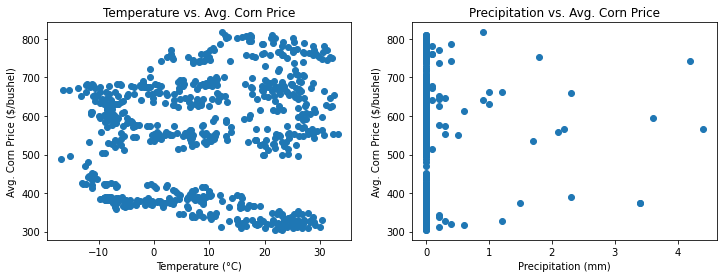

In [53]:
# Plotting weather data vs. corn price
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(X_train['temperature_2m_mean'], y_train)
axs[0].set_xlabel('Temperature (°C)')
axs[0].set_ylabel('Avg. Corn Price ($/bushel)')
axs[0].set_title('Temperature vs. Avg. Corn Price')

axs[1].scatter(X_train['precipitation_sum'], y_train)
axs[1].set_xlabel('Precipitation (mm)')
axs[1].set_ylabel('Avg. Corn Price ($/bushel)')
axs[1].set_title('Precipitation vs. Avg. Corn Price')

Our first attempt at a model then was to fit a multi-layer perceptron. This neural network will have $2, 100 \times 100$ fully connected hidden layers and use the default ReLU activation function (`relu(x) = max(x, 0)`). 

In [54]:
# Initializing and fitting the MLP to scaled
mlp = MLPRegressor((100, 100), random_state=123, max_iter=10000)
mlp.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=123)

In [55]:
mse = mean_squared_error(y_test, mlp.predict(X_test_scaled))
print(f"MSE of MLPRegressor: {mse}")

MSE of MLPRegressor: 320.8440379280031


The MLP Regressor got a mean squared error of ~321. We'll use more complicated neural network architectures below to see if we can get a better result. 

Based on the plots, there doesn't seem to be a strong correlation between temperature and precipitation with corn prices. It's also possible that the relationship between weather and corn prices is more complex than a simple linear relationship, and may require further analysis to uncover.

In [ ]:
# corr_matrix = merged_data_scaled[['avg_price', 'temperature_2m_mean', 'precipitation_sum']].corr()
# print(corr_matrix)

In [ ]:
# sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

In [ ]:
# lr2 = LinearRegression()
# X = merged_data_scaled.drop('avg_price', axis=1)
# y = merged_data_scaled['avg_price']

# mse_scores = -cross_val_score(lr2, X, y, cv=5, scoring='neg_mean_squared_error')

# print(f"Average MSE: {mse_scores.mean():.4f}, Standard deviation: {mse_scores.std():.4f}")

### RNN Regression

TODO: explanation

In [ ]:
pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [ ]:
y_train

#### Basic RNN model with Adam optimizer and L2 regularization

##### Training

First, we need to set hyperparameters for our RNN model. After experimenting with various different configurations, below are the hyperparameters that I found to be best

In [57]:
# TODO: Split up code cells and walk through what's happening at each step


# Set hyperparameters

input_size = 17
hidden_size = 64
output_size = 1
num_epochs = 1000
batch_size = 32
learning_rate = 0.001
sequence_length = 1

# Prepare the train dataset
X_train_arr = np.array(X_train_scaled)
y_train_arr = np.array(y_train)

X_train_arr = X_train_arr.reshape(-1, sequence_length, input_size)
y_train_arr = y_train_arr.reshape(-1, sequence_length, output_size)

train_dataset = TensorDataset(torch.tensor(X_train_arr).float(), torch.tensor(y_train_arr).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
rnn_model_instance = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model_instance.parameters(), lr=learning_rate, weight_decay=1e-5)  # Add weight_decay for L2 regularization

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = rnn_model_instance(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



##### Testing

In [ ]:
# Prepare the test dataset
X_test_arr = np.array(X_test_scaled)
y_test_arr = np.array(y_test)

X_test_arr = X_test_arr.reshape(-1, sequence_length, input_size)
y_test_arr = y_test_arr.reshape(-1, sequence_length, output_size)

test_dataset = TensorDataset(torch.tensor(X_test_arr).float(), torch.tensor(y_test_arr).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model
rnn_model_instance.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = rnn_model_instance(inputs)
        predictions.extend(outputs.numpy().flatten())
        actuals.extend(targets.numpy().flatten())

# Calculate accuracy metrics
mae_rnn = mean_absolute_error(actuals, predictions)
mse_rnn = mean_squared_error(actuals, predictions)
rmse_rnn = np.sqrt(mse_rnn)

print(f'Mean Absolute Error: {mae_rnn:.4f}')
print(f'Mean Squared Error: {mse_rnn:.4f}')
print(f'Root Mean Squared Error: {rmse_rnn:.4f}')

#### GRU model with Adam optimizer and L2 Regularization

##### Training

In [ ]:
# Set hyperparameters

input_size = 17
hidden_size = 64
output_size = 1
num_epochs = 1000
batch_size = 32
learning_rate = 0.001
sequence_length = 1

# Prepare the train dataset
X_train_arr = np.array(X_train_scaled)
y_train_arr = np.array(y_train)

X_train_arr = X_train_arr.reshape(-1, sequence_length, input_size)
y_train_arr = y_train_arr.reshape(-1, sequence_length, output_size)

train_dataset = TensorDataset(torch.tensor(X_train_arr).float(), torch.tensor(y_train_arr).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
gru_model_instance = GRUModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model_instance.parameters(), lr=learning_rate, weight_decay=1e-5)

# Train the modelt
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = gru_model_instance(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


##### Testing

In [ ]:
# Prepare the test dataset
X_test_arr = np.array(X_test_scaled)
y_test_arr = np.array(y_test)

X_test_arr = X_test_arr.reshape(-1, sequence_length, input_size)
y_test_arr = y_test_arr.reshape(-1, sequence_length, output_size)

test_dataset = TensorDataset(torch.tensor(X_test_arr).float(), torch.tensor(y_test_arr).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model
gru_model_instance.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = gru_model_instance(inputs)
        predictions.extend(outputs.numpy().flatten())
        actuals.extend(targets.numpy().flatten())

# Calculate accuracy metrics
mae_gru = mean_absolute_error(actuals, predictions)
mse_gru = mean_squared_error(actuals, predictions)
rmse_gru = np.sqrt(mse_gru)

print(f'Mean Absolute Error: {mae_gru:.4f}')
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'Root Mean Squared Error: {rmse_gru:.4f}')

### Shapley Values of our Best Model

In [ ]:
best_model = rnn_model_instance if rmse_rnn <= rmse_gru else gru_model_instance

def model_wrapper(x):
    x_tensor = torch.FloatTensor(x).unsqueeze(1)
    with torch.no_grad():
        output = best_model(x_tensor)
    return output.numpy()

# Initialize the explainer
explainer = shap.Explainer(model_wrapper, X_train_scaled)

# Compute SHAP values for X_test
shap_values = explainer(X_test_scaled)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)